In [1]:
from google.colab import drive
drive.mount('/content/drive')

!unzip -q '/content/drive/MyDrive/HAM10000.zip' -d '/content/skin_data'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
import shutil
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [3]:
metadata_path = '/content/skin_data/HAM10000_metadata.csv'
images_path_1 = '/content/skin_data/HAM10000_images_part_1/'
images_path_2 = '/content/skin_data/HAM10000_images_part_2/'
output_path = '/content/dataset_split'

In [4]:
df = pd.read_csv(metadata_path)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lesion_id     10015 non-null  object 
 1   image_id      10015 non-null  object 
 2   dx            10015 non-null  object 
 3   dx_type       10015 non-null  object 
 4   age           9958 non-null   float64
 5   sex           10015 non-null  object 
 6   localization  10015 non-null  object 
dtypes: float64(1), object(6)
memory usage: 547.8+ KB


In [5]:
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [6]:
# ambil beberapa class aja yang most_common dari dx(kategori penyakit)
selected_classes = ['nv', 'mel', 'bcc', 'bkl']
df = df[df['dx'].isin(selected_classes)]

# gabungin semua gambar ke 1 folder
all_images_dir = '/content/HAM10000_all_images'
os.makedirs(all_images_dir, exist_ok=True)

for folder in [images_path_1, images_path_2]:
  for file in os.listdir(folder):
    shutil.copy(os.path.join(folder, file), all_images_dir)

In [7]:
df['image_path'] = df['image_id'].apply(lambda x: os.path.join(all_images_dir, x + '.jpg'))
df = df[['image_path', 'dx']]

print('Classes kept:', df['dx'].unique(), " | Total images:", len(df))

Classes kept: ['bkl' 'nv' 'mel' 'bcc']  | Total images: 9431


In [8]:
from sklearn.utils.class_weight import compute_class_weight

In [9]:
# kek biasa split data ke train test val 80 10 10

train_df, temp_df = train_test_split(df, test_size=0.2, stratify=df['dx'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['dx'], random_state=42)

print('Train size:', len(train_df))
print('Val size:', len(val_df))
print('Test size:', len(test_df))

Train size: 7544
Val size: 943
Test size: 944


In [10]:
# pisahin dataset masing2 ke folder
def save_split(split_df, split_name):
    for _, row in split_df.iterrows():
        class_name = row['dx']
        img_src = row['image_path']
        split_dir = os.path.join(output_path, split_name, class_name)
        os.makedirs(split_dir, exist_ok=True)
        shutil.copy(img_src, os.path.join(split_dir, os.path.basename(img_src)))

save_split(train_df, 'train')
save_split(val_df, 'val')
save_split(test_df, 'test')

print('Dataset organized into:', output_path)

Dataset organized into: /content/dataset_split


In [11]:
# training model

In [12]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [13]:
# preprocess input
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.1
)

val_test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

train_gen = train_datagen.flow_from_directory(
    os.path.join(output_path, 'train'),
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical'
)

val_gen = val_test_datagen.flow_from_directory(
    os.path.join(output_path, 'val'),
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical'
)

test_gen = val_test_datagen.flow_from_directory(
    os.path.join(output_path, 'test'),
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 7544 images belonging to 4 classes.
Found 943 images belonging to 4 classes.
Found 944 images belonging to 4 classes.


In [14]:
# memberikan class weight untuk memberikan penalti lebih besar untuk class yang lebih rare
class_indices = train_gen.class_indices
labels = list(class_indices.keys())
print('Labels:', labels)
class_weight = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_gen.classes),
    y = train_gen.classes
)

class_weight_dict = dict(enumerate(class_weight))
print('Class Weights:', class_weight_dict)

Labels: ['bcc', 'bkl', 'mel', 'nv']
Class Weights: {0: np.float64(4.588807785888078), 1: np.float64(2.1456200227531284), 2: np.float64(2.1191011235955055), 3: np.float64(0.3516032811334825)}


In [15]:
# pake model EfficientNetB0 dari google
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224,224,3))
base_model.trainable = False
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
preds = Dense(train_gen.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=preds)

# freeze base modelnya biar bisa kita pake buat transfer learning
# for layer in base_model.layers:
#   layer.trainable = False

model.compile(optimizer=Adam(1e-3), loss='categorical_crossentropy', metrics=['accuracy'])

# callback
# checkpoint_h5 = ModelCheckpoint(
#     'best_model.h5',
#     monitor='val_loss',
#     save_best_only=True,
#     mode='min'
#     )

checkpoint_tf = ModelCheckpoint(
    'best_model_tf.keras',
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    save_weights_only=False
    )

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [16]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=100,
    callbacks=[checkpoint_tf, early_stop],
    class_weight=class_weight_dict
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
236/236 ━━━━━━━━━━━━━━━━━━━━ 130s 434ms/step - accuracy: 0.4984 - loss: 1.2527 - val_accuracy: 0.6766 - val_loss: 0.8205
Epoch 2/100
236/236 ━━━━━━━━━━━━━━━━━━━━ 63s 266ms/step - accuracy: 0.6636 - loss: 0.9380 - val_accuracy: 0.7179 - val_loss: 0.7538
Epoch 3/100
236/236 ━━━━━━━━━━━━━━━━━━━━ 59s 252ms/step - accuracy: 0.6809 - loss: 0.8505 - val_accuracy: 0.6829 - val_loss: 0.8183
Epoch 4/100
236/236 ━━━━━━━━━━━━━━━━━━━━ 55s 233ms/step - accuracy: 0.6961 - loss: 0.8122 - val_accuracy: 0.7094 - val_loss: 0.7399
Epoch 5/100
236/236 ━━━━━━━━━━━━━━━━━━━━ 56s 235ms/step - accuracy: 0.7003 - loss: 0.8109 - val_accuracy: 0.7381 - val_loss: 0.6875
Epoch 6/100
236/236 ━━━━━━━━━━━━━━━━━━━━ 56s 236ms/step - accuracy: 0.7150 - loss: 0.7856 - val_accuracy: 0.7052 - val_loss: 0.7387
Epoch 7/100
236/236 ━━━━━━━━━━━━━━━━━━━━ 57s 240ms/step - accuracy: 0.6989 - loss: 0.7722 - val_accuracy: 0.7381 - val_loss: 0.6587
Epoch 8/100
236/236 ━━━━━━━━━━━━━━━━━━━━ 55s 234ms/step - accuracy: 0.7118 

In [17]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

In [18]:
def get_img_array(img_path, size=(224, 224)):
    """Loads image and preprocesses it for EfficientNetB0"""
    img = image.load_img(img_path, target_size=size)
    array = image.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    array = tf.keras.applications.efficientnet.preprocess_input(array)
    return array

In [19]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    """Creates Grad-CAM heatmap for a specific prediction."""
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]

    heatmap = tf.reduce_mean(conv_outputs * pooled_grads, axis=-1)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [20]:
def display_gradcam_triplet(img_path, heatmap, alpha=0.4):
    """Displays original image, heatmap, and Grad-CAM overlay side-by-side."""
    # Load original
    img = image.load_img(img_path)
    img = image.img_to_array(img)

    # Prepare resized heatmap
    heatmap = np.uint8(255 * heatmap)
    heatmap_resized = tf.image.resize(
        np.expand_dims(heatmap, -1), (img.shape[0], img.shape[1])
    )
    heatmap_color = np.repeat(heatmap_resized.numpy(), 3, axis=-1)

    # Overlay
    overlay = np.uint8(img * (1 - alpha) + heatmap_color * alpha)

    # Plot
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].imshow(img.astype("uint8"))
    ax[0].set_title("Original Image")
    ax[0].axis("off")

    ax[1].imshow(heatmap, cmap="jet")
    ax[1].set_title("Grad-CAM Heatmap")
    ax[1].axis("off")

    ax[2].imshow(overlay.astype("uint8"))
    ax[2].set_title("Overlay (Grad-CAM)")
    ax[2].axis("off")

    plt.tight_layout()
    plt.show()

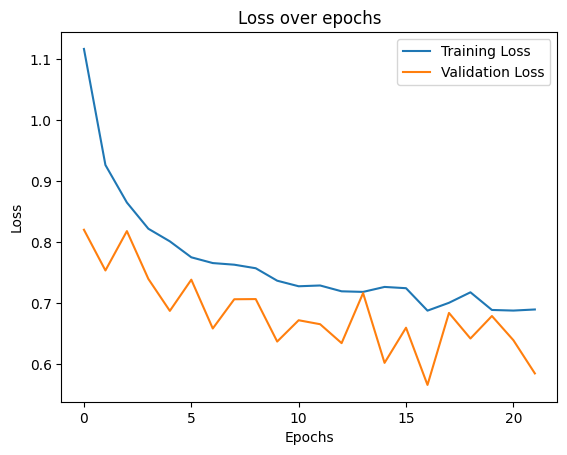

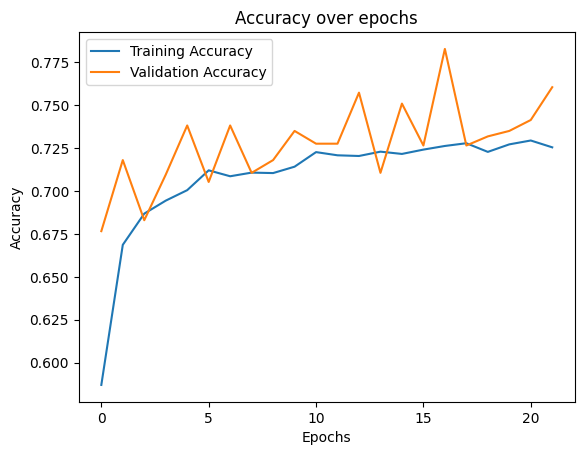

In [21]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training & validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [22]:
base_model.trainable = True
model.compile(optimizer=Adam(1e-5), loss="categorical_crossentropy", metrics=["accuracy"])

history2 = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=100,
    class_weight=class_weight_dict,
    callbacks=[checkpoint_tf, early_stop]
)

Epoch 1/100
236/236 ━━━━━━━━━━━━━━━━━━━━ 194s 486ms/step - accuracy: 0.3155 - loss: 1.5394 - val_accuracy: 0.5992 - val_loss: 1.0439
Epoch 2/100
236/236 ━━━━━━━━━━━━━━━━━━━━ 60s 254ms/step - accuracy: 0.4834 - loss: 1.1511 - val_accuracy: 0.6511 - val_loss: 0.9703
Epoch 3/100
236/236 ━━━━━━━━━━━━━━━━━━━━ 65s 274ms/step - accuracy: 0.5883 - loss: 0.9414 - val_accuracy: 0.6935 - val_loss: 0.8621
Epoch 4/100
236/236 ━━━━━━━━━━━━━━━━━━━━ 60s 253ms/step - accuracy: 0.6493 - loss: 0.8417 - val_accuracy: 0.7147 - val_loss: 0.7802
Epoch 5/100
236/236 ━━━━━━━━━━━━━━━━━━━━ 60s 253ms/step - accuracy: 0.6712 - loss: 0.7979 - val_accuracy: 0.7275 - val_loss: 0.7420
Epoch 6/100
236/236 ━━━━━━━━━━━━━━━━━━━━ 83s 257ms/step - accuracy: 0.7030 - loss: 0.7170 - val_accuracy: 0.7508 - val_loss: 0.6875
Epoch 7/100
236/236 ━━━━━━━━━━━━━━━━━━━━ 61s 256ms/step - accuracy: 0.7207 - loss: 0.6688 - val_accuracy: 0.7550 - val_loss: 0.6689
Epoch 8/100
236/236 ━━━━━━━━━━━━━━━━━━━━ 81s 254ms/step - accuracy: 0.7330 

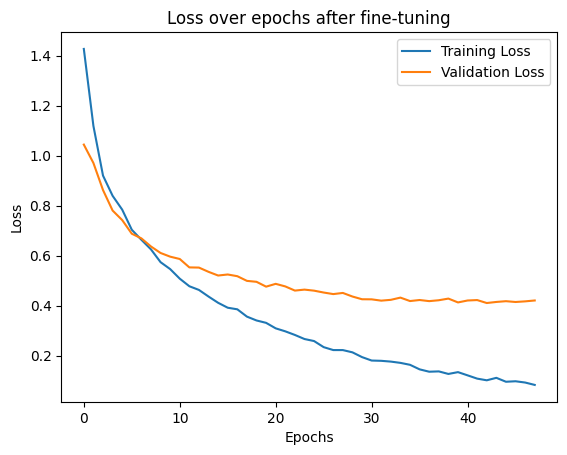

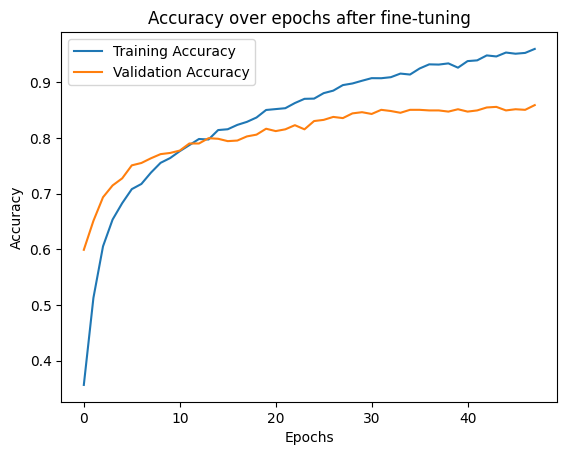

In [23]:
plt.plot(history2.history['loss'], label='Training Loss')
plt.plot(history2.history['val_loss'], label='Validation Loss')
plt.title('Loss over epochs after fine-tuning')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training & validation accuracy
plt.plot(history2.history['accuracy'], label='Training Accuracy')
plt.plot(history2.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over epochs after fine-tuning')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [24]:
from tensorflow.keras.models import load_model
model = load_model('best_model_tf.keras')

In [25]:
test_loss, test_acc = model.evaluate(test_gen, verbose=1)
print(f'Test Acc: {test_acc*100:.2f}%')
print(f'Test Loss: {test_loss:.4f}')

30/30 ━━━━━━━━━━━━━━━━━━━━ 28s 632ms/step - accuracy: 0.8229 - loss: 0.5330
Test Acc: 85.59%
Test Loss: 0.4242


In [26]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [27]:
y_pred_prob = model.predict(test_gen)

y_pred = np.argmax(y_pred_prob, axis=1)
y_true = test_gen.classes

print(classification_report(y_true, y_pred, target_names=list(test_gen.class_indices.keys())))

30/30 ━━━━━━━━━━━━━━━━━━━━ 19s 406ms/step
              precision    recall  f1-score   support

         bcc       0.71      0.82      0.76        51
         bkl       0.68      0.85      0.75       110
         mel       0.64      0.62      0.63       112
          nv       0.95      0.90      0.92       671

    accuracy                           0.86       944
   macro avg       0.74      0.80      0.77       944
weighted avg       0.86      0.86      0.86       944



1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
Predicted class: bkl


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


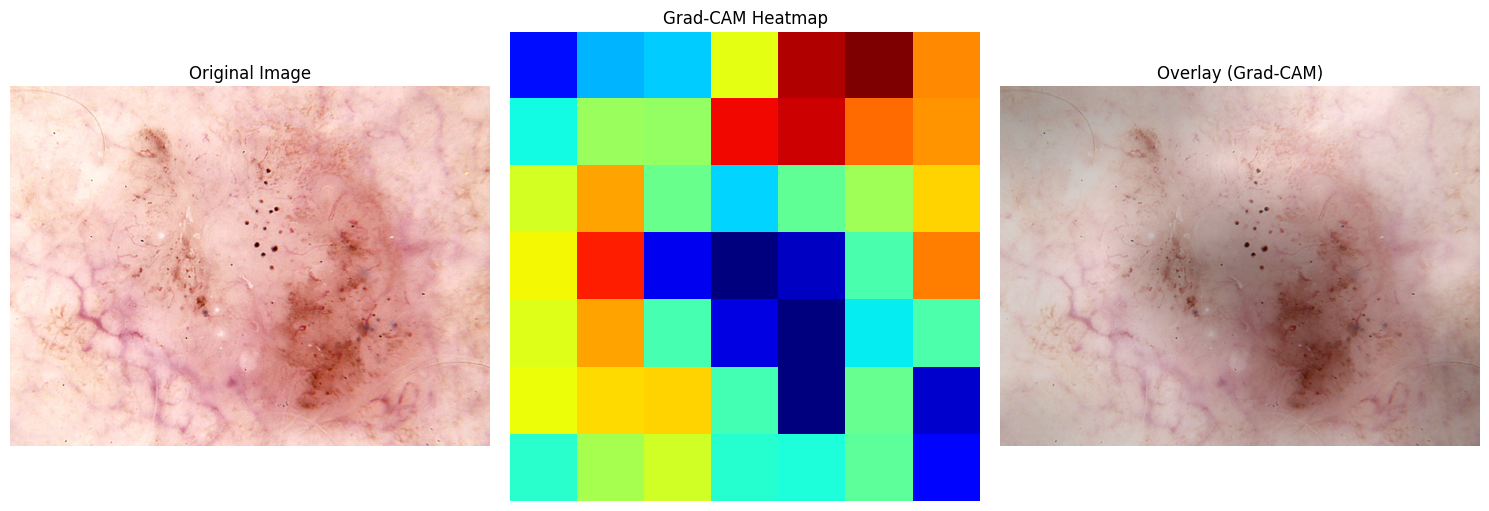

In [28]:
img_path = test_gen.filepaths[10]

img_array = get_img_array(img_path)
preds = model.predict(img_array)
pred_class = np.argmax(preds[0])
class_name = list(test_gen.class_indices.keys())[pred_class]

print(f"Predicted class: {class_name}")

# EfficientNetB0’s last conv layer name is "top_conv"
heatmap = make_gradcam_heatmap(
    img_array, model, last_conv_layer_name="top_conv"
)

display_gradcam_triplet(img_path, heatmap)

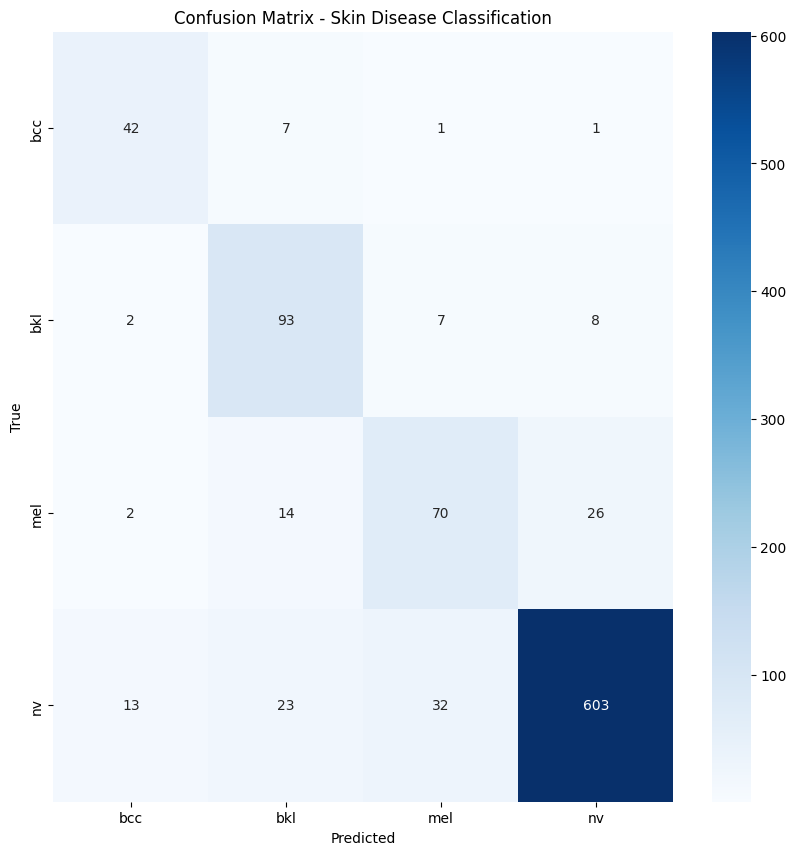

In [29]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_gen.class_indices.keys(), yticklabels=test_gen.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Skin Disease Classification')
plt.show()